In [142]:
import re
import time
import warnings

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [143]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
train.shape

(7613, 5)

In [144]:
train.target.value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

In [145]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [146]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [147]:
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test.shape

(3263, 4)

In [148]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [149]:

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

stop_words = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [150]:
def cleaning(text):    
    text = text.lower()
    
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and len(word) > 1]
    
    text_processed = ' '.join(words)
    
    return text_processed

In [151]:
train["text"] = train["text"].apply(cleaning)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [152]:
test["text"] = test["text"].apply(cleaning)
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


In [153]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [180]:
df_train, df_test = train_test_split(train, stratify = train.target, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(df_train.text, df_train.target, stratify = df_train.target, test_size = 0.5, random_state = 42)

In [155]:
features_test = test["text"].values

In [156]:
tfidf = TfidfVectorizer(lowercase = False)

pipe_classification = Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer = 'word',
        lowercase = True,
        min_df = 5,
        max_features = 30000,
        tokenizer = tokenizer_porter
    )),  
    ('classifier', LogisticRegression(solver = 'liblinear', random_state = 42))
])


In [175]:
parameter_grid = {
    'vectorizer__max_features': [10000, 13000],
    'vectorizer__min_df': [1, 2],
    'vectorizer__ngram_range': [(1, 2)],
    'classifier__C': [10],
    'classifier__penalty': ['l2']
}

In [158]:
warnings.filterwarnings("ignore")

In [181]:
grid_search = GridSearchCV(
    estimator = pipe_classification,
    param_grid = parameter_grid,
    cv = 5,
    scoring = 'f1',
    verbose = 1,
)

grid_search.fit(X_train, y_train)

print(f"\nBest F1-score: {grid_search.best_score_:.4f}\n")

print("Best parameters combination found:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best F1-score: 0.7238

Best parameters combination found:
classifier__C: 10
classifier__penalty: l2
vectorizer__max_features: 10000
vectorizer__min_df: 1
vectorizer__ngram_range: (1, 2)


In [182]:
best_text_pipeline = grid_search.best_estimator_

In [183]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

auc_scores = cross_val_score(best_text_pipeline, X_train, y_train, cv = cv, scoring = 'f1')
print(auc_scores)
print(f'Mean: {round(auc_scores.mean(), 4)}')
print(f'Std: {round(auc_scores.std(), 4)}')
print(f'3 std range: [{round(auc_scores.mean() - 3*auc_scores.std(), 4)}, {round(auc_scores.mean() + 3*auc_scores.std(), 4)}]')

[0.70731707 0.72798434 0.71683168 0.74901961 0.68714012]
Mean: 0.7177
Std: 0.0206
3 std range: [0.6558, 0.7796]


In [184]:
proba_val = best_text_pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, proba_val)

0.8349583361942539

In [185]:
def f_metrics(y, proba):
    f_metrics = []
    tholds = [0.1, 0.25, 0.5, 0.75, 0.9]
    for th in [0.1, 0.25, 0.5, 0.75, 0.9]:
        f_metrics.append({
            'positives_ratio': (proba >= th).sum()/proba_val.shape[0],
            'precision': precision_score(y, proba >= th),
            'recall': recall_score(y, proba >= th),
            'f1': f1_score(y, proba >= th),
        })
    return pd.DataFrame(f_metrics, index=tholds)

In [186]:
f_metrics(y_val, proba_val)

,positives_ratio,precision,recall,f1
0.10,0.802627,0.500409,0.935015,0.651919
0.25,0.600328,0.605580,0.846330,0.705995
0.50,0.420033,0.741986,0.725535,0.733668
0.75,0.266338,0.866831,0.537462,0.663521
0.90,0.144171,0.952164,0.319572,0.478535


In [187]:
proba_test = best_text_pipeline.predict_proba(df_test.text)[:, 1]
roc_auc_score(df_test.target, proba_test)

0.8440833254153426

In [188]:
f_metrics(df_test.target, proba_test)

,positives_ratio,precision,recall,f1
0.10,0.410181,0.500400,0.955657,0.656858
0.25,0.305747,0.607948,0.865443,0.714196
0.50,0.206240,0.751592,0.721713,0.736349
0.75,0.140558,0.871495,0.570336,0.689464
0.90,0.080460,0.926531,0.347095,0.505006


**Adversial validation**

In [189]:
df_adversarial = pd.concat([train, test]).reset_index()
df_adversarial.target = len(train)*[0] + len(test)*[1]

X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(
    df_adversarial.text, df_adversarial.target, stratify = df_adversarial.target, test_size = 0.3, random_state = 42
)

pipe_classification.fit(X_train_adv, y_train_adv)

proba = best_text_pipeline.predict_proba(X_val_adv)[:, 1]
roc_auc_score(y_val_adv, proba)

0.5135304172204741

In [190]:
test_predictions = best_text_pipeline.predict(features_test)

In [191]:
test["target_predicted"] = test_predictions
test[["id", "text", "target_predicted"]].sample(n = 15, random_state = 42)

,id,text,target_predicted
2406,8051,refugees citizens hindu,1
134,425,sostag honestly could say apocalypse coming wo...,0
411,1330,bored shit dont nobody fuck wit busy yo shit g...,0
203,663,realtwanbrown yesterday heat attack whats funn...,1
889,2930,devil wears prada still one favourite films,0
1432,4743,father fucking died north tower collapsed tryi...,1
3024,9981,oh soccer ball thought head melting snowman,0
2741,9129,bestnaijamade yr old pkk suicide bomber detona...,1
463,1490,complexmag asking body bags pushat,0
291,943,junesnowpaw yeah gim dat creamy white stuff,0


In [ ]:
submission = pd.DataFrame(
    data = {
        'id': test.id,
        'target': test_predictions,
    }
)

submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)

# Summary

**I conducted an adversarial validation, yielding a score of 0.514. This result is very close to 0.5, suggesting a similarity between our training and test data. Furthermore, I noticed that my results from local validation and the public leaderboard (PL) are quite close, although the PL metrics (0.76953) are higher than the local validation metrics (0.73). In my opinion, this slight disparity could be attributed to the natural variance expected between the text in the test dataset, which differs from the training dataset. Additionally, our model might be underfitting, missing some patterns. These discrepancies can result in minor variations in performance metrics. However, our F1 accuracy on the public leaderboard falls within the 3rd standard deviation range, indicating a reasonably accurate situation.**

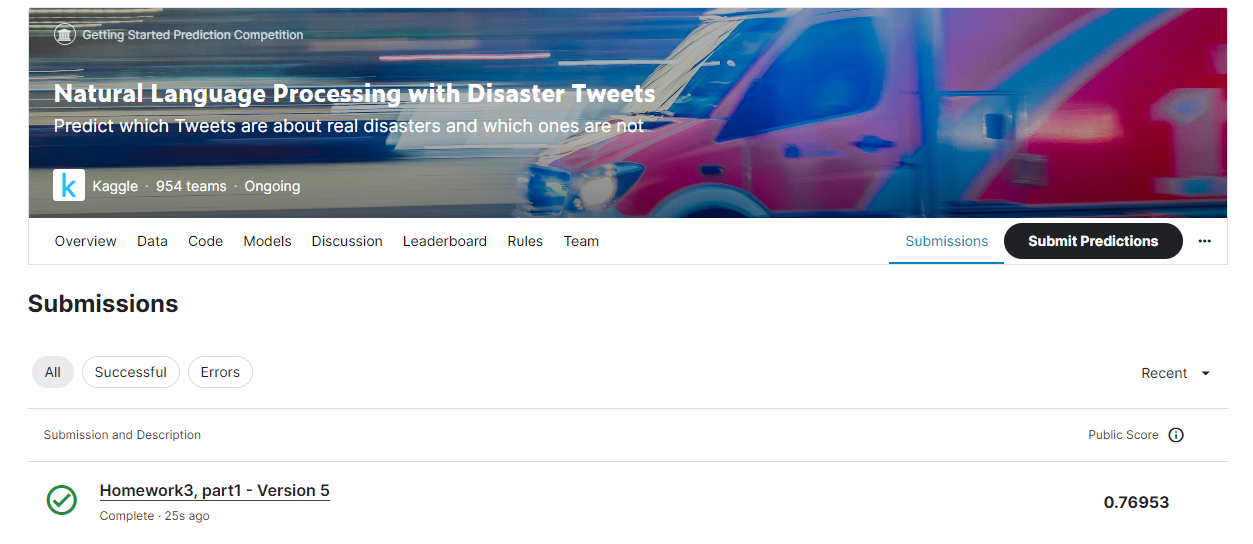